In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # type: ignore
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout # type: ignore
from tensorflow.keras.preprocessing.image import load_img, img_to_array # type: ignore
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# Set image size
IMG_SIZE = 128

# Load images (RGB)
def load_images(path):
    images = []
    for file in os.listdir(path):
        img = load_img(os.path.join(path, file), target_size=(IMG_SIZE, IMG_SIZE))
        img = img_to_array(img) / 255.0  # Normalize
        images.append(img)
    return np.array(images)

# Load segmentation masks (Grayscale)
def load_masks(path):
    masks = []
    for file in os.listdir(path):
        img = load_img(os.path.join(path, file), target_size=(IMG_SIZE, IMG_SIZE), color_mode="grayscale")
        img = img_to_array(img) / 255.0  # Normalize to [0,1]
        img = np.expand_dims(img, axis=-1)  # Add channel dimension (H, W, 1)
        masks.append(img)
    return np.array(masks)

# Set dataset paths
image_path = "C:\\Users\\Srimithun A\\Downloads\\tumor seg\\data\\data\\images"
mask_path = "C:\\Users\\Srimithun A\\Downloads\\tumor seg\\data\\data\\masks"

# Load dataset
X = load_images(image_path)
y = load_masks(mask_path)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define U-Net model
def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2,2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(c4)
    c4 = Dropout(0.3)(c4)
    c4 = BatchNormalization()(c4)

    # Decoder
    u1 = UpSampling2D((2,2))(c4)
    u1 = concatenate([u1, c3])
    c5 = Conv2D(256, (3,3), activation='relu', padding='same')(u1)
    c5 = BatchNormalization()(c5)
    
    u2 = UpSampling2D((2,2))(c5)
    u2 = concatenate([u2, c2])
    c6 = Conv2D(128, (3,3), activation='relu', padding='same')(u2)
    c6 = BatchNormalization()(c6)
    
    u3 = UpSampling2D((2,2))(c6)
    u3 = concatenate([u3, c1])
    c7 = Conv2D(64, (3,3), activation='relu', padding='same')(u3)
    c7 = BatchNormalization()(c7)
    
    outputs = Conv2D(1, (1,1), activation='sigmoid')(c7)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Callbacks to prevent overfitting
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)
]

# Train model
model = unet_model()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=16,
    callbacks=callbacks
)

# Save trained model
model.save("optimized_brain_tumor_segmentation22.h5")


Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8260 - loss: 0.5708

154/154 ━━━━━━━━━━━━━━━━━━━━ 420s 3s/step - accuracy: 0.8266 - loss: 0.5696 - val_accuracy: 0.9705 - val_loss: 0.3373
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9871 - loss: 0.1051

154/154 ━━━━━━━━━━━━━━━━━━━━ 421s 3s/step - accuracy: 0.9871 - loss: 0.1050 - val_accuracy: 0.9822 - val_loss: 0.1207
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9887 - loss: 0.0471

154/154 ━━━━━━━━━━━━━━━━━━━━ 423s 3s/step - accuracy: 0.9887 - loss: 0.0470 - val_accuracy: 0.9800 - val_loss: 0.1206
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9894 - loss: 0.0361

154/154 ━━━━━━━━━━━━━━━━━━━━ 422s 3s/step - accuracy: 0.9895 - loss: 0.0361 - val_accuracy: 0.9704 - val_loss: 0.0845
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9913 - loss: 0.0271

154/154 ━━━━━━━━━━━━━━━━━━━━ 421s 3s/step - accuracy: 0.9913 - loss: 0.0271 - val_accuracy: 0.9887 - val_loss: 0.0408
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9919 - loss: 0.0238

154/154 ━━━━━━━━━━━━━━━━━━━━ 418s 3s/step - accuracy: 0.9919 - loss: 0.0238 - val_accuracy: 0.9913 - val_loss: 0.0286
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 447s 3s/step - accuracy: 0.9928 - loss: 0.0210 - val_accuracy: 0.9857 - val_loss: 0.0408
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9936 - loss: 0.0182

154/154 ━━━━━━━━━━━━━━━━━━━━ 415s 3s/step - accuracy: 0.9936 - loss: 0.0182 - val_accuracy: 0.9915 - val_loss: 0.0242
Epoch 9/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9943 - loss: 0.0159

154/154 ━━━━━━━━━━━━━━━━━━━━ 413s 3s/step - accuracy: 0.9943 - loss: 0.0159 - val_accuracy: 0.9914 - val_loss: 0.0241
Epoch 10/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9947 - loss: 0.0144

154/154 ━━━━━━━━━━━━━━━━━━━━ 412s 3s/step - accuracy: 0.9947 - loss: 0.0144 - val_accuracy: 0.9930 - val_loss: 0.0211


In [4]:
def segment_brain_tumor(image_path, model, threshold=0.6):
    img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    pred_mask = model.predict(img_array)[0]
    pred_mask = (pred_mask > threshold).astype(np.uint8)  # Increased threshold
    
    return img, pred_mask

def check_tumor(mask):
    return np.sum(mask) > 0  # If mask has non-zero pixels, tumor exists

In [5]:
def select_image_and_predict(image_path):
    model = tf.keras.models.load_model("optimized_brain_tumor_segmentation22.h5")
    original, mask = segment_brain_tumor(image_path, model)
    predicted_mask = mask.squeeze()

    tumor_exists = check_tumor(mask)
    print("Tumor Detected!" if tumor_exists else "No Tumor Found.")
    
    # Display MRI Image and Predicted Mask
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original MRI")
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap="gray")
    plt.title("Predicted Tumor Mask")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
Tumor Detected!


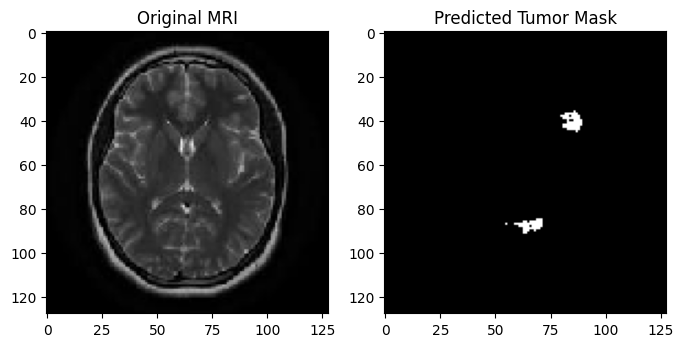

In [6]:
# Example usage
image_path = "mri.jpeg"  # Set the MRI image file path here
select_image_and_predict(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Tumor Detected!


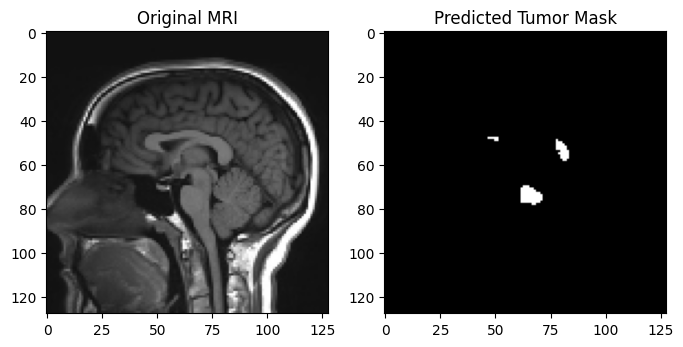

In [7]:
# Example usage
image_path = "mri2.jpeg"  # Set the MRI image file path here
select_image_and_predict(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
Tumor Detected!


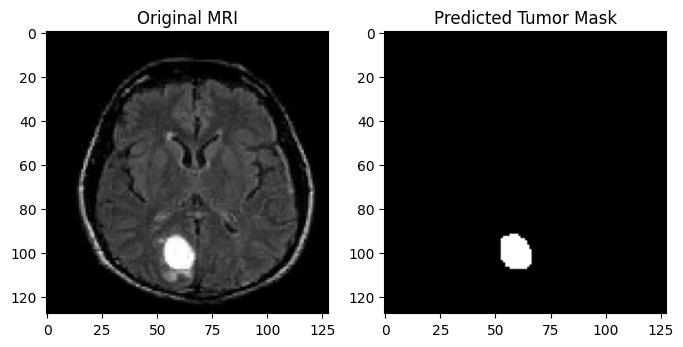

In [8]:
# Example usage
image_path = "mri3.png"  # Set the MRI image file path here
select_image_and_predict(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
Tumor Detected!


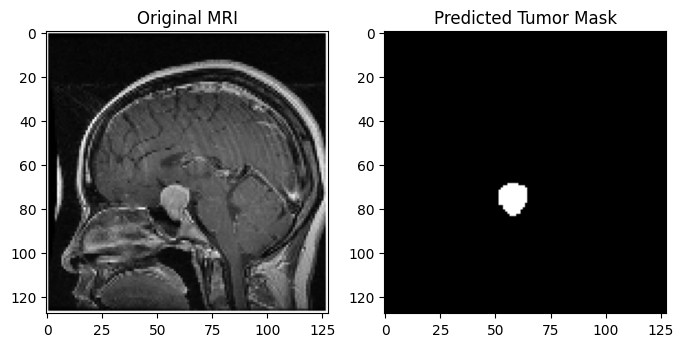

In [9]:
# Example usage
image_path = "mri4.jpg"  # Set the MRI image file path here
select_image_and_predict(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
Tumor Detected!


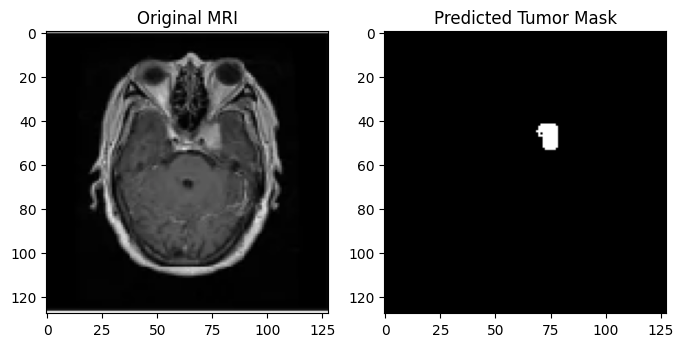

In [10]:
# Example usage
image_path = "mri5.png"  # Set the MRI image file path here
select_image_and_predict(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
Tumor Detected!


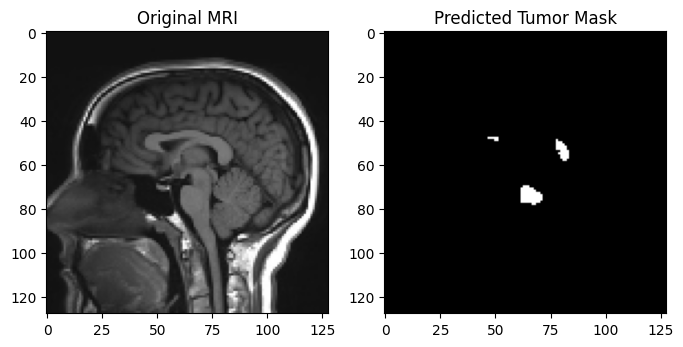

In [14]:
# Example usage
image_path = "mri7.jpeg"  # Set the MRI image file path here
select_image_and_predict(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
Tumor Detected!


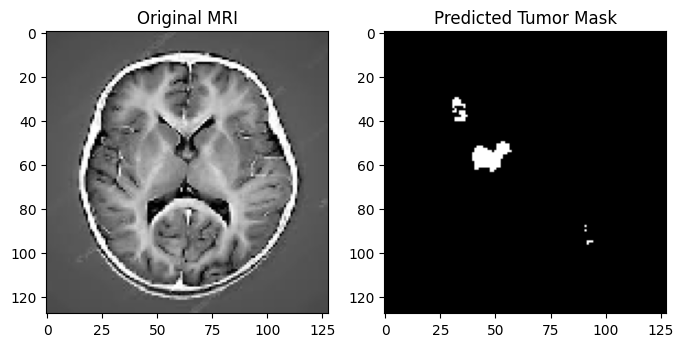

In [16]:
# Example usage
image_path = "mri6.jpeg"  # Set the MRI image file path here
select_image_and_predict(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
No Tumor Found.


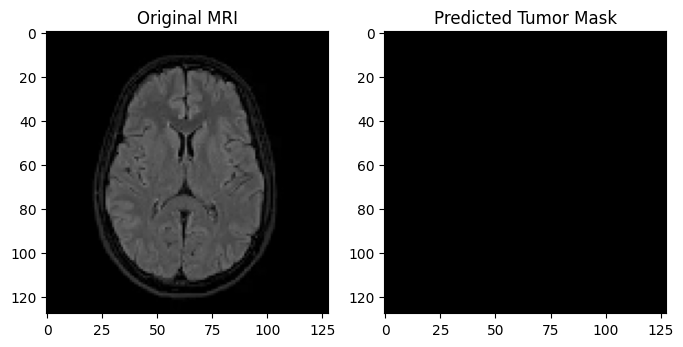

In [17]:
# Example usage
image_path = "mri8.jpg"  # Set the MRI image file path here
select_image_and_predict(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
No Tumor Found.


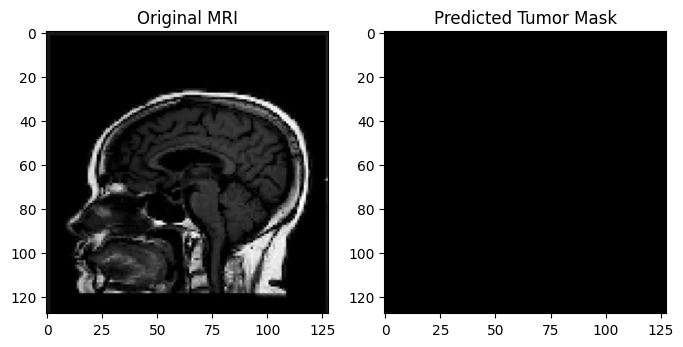

In [18]:
# Example usage
image_path = "mri9.jpeg"  # Set the MRI image file path here
select_image_and_predict(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
Tumor Detected!


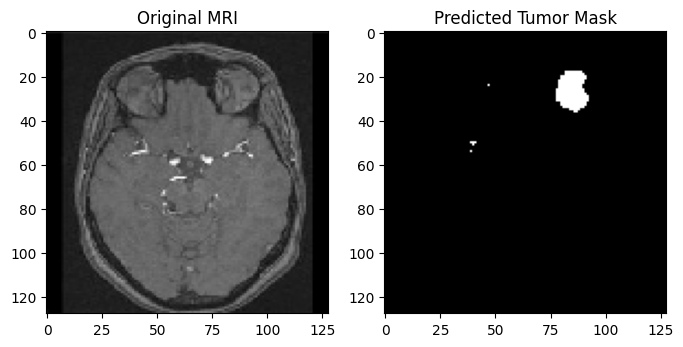

In [20]:
# Example usage
image_path = "mri10.jpg"  # Set the MRI image file path here
select_image_and_predict(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
Tumor Detected!


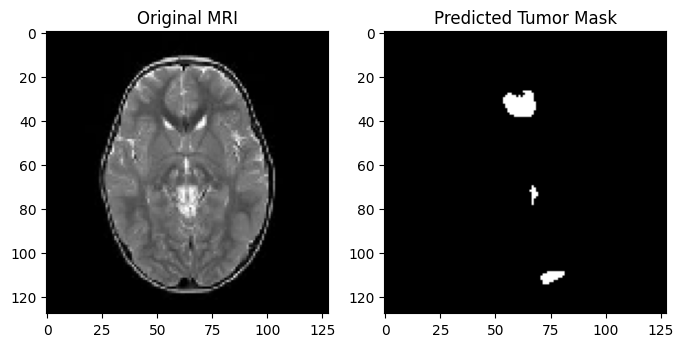

In [21]:
# Example usage
image_path = "mri11.jpg"  # Set the MRI image file path here
select_image_and_predict(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
Tumor Detected!


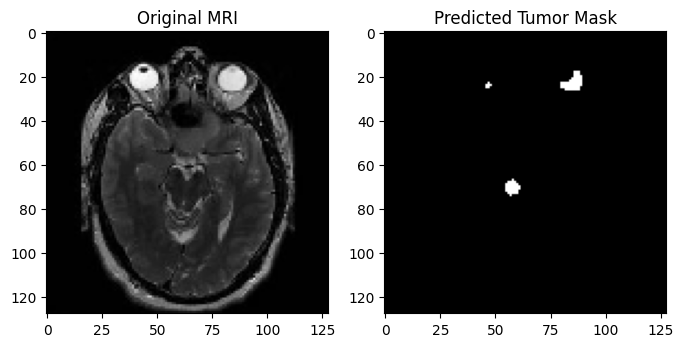

In [22]:
# Example usage
image_path = "mri12.jpg"  # Set the MRI image file path here
select_image_and_predict(image_path)